## Overfitting and Underfitting
Improve performance with extra capacity or early stopping.

## <span style=color:highlight> ***Introduction*** </span>
Recall from the example in the previous lesson that Keras will keep a history of the training and validation loss over the epochs that it is training the model. In this lesson, we're going to learn how to interpret these learning curves and how we can use them to guide model development. In particular, we'll examine at the learning curves for evidence of underfitting and overfitting and look at a couple of strategies for correcting it.

## <span style=color:highlight> Interpreting the Learning Curves </span>
You might think about the information in the training data as being of two kinds: signal and noise. The signal is the part that generalizes, the part that can help our model make predictions from new data. The noise is that part that is only true of the training data; the noise is all of the random fluctuation that comes from data in the real-world or all of the incidental, non-informative patterns that can't actually help the model make predictions. The noise is the part might look useful but really isn't.

We train a model by choosing weights or parameters that minimize the loss on a training set. You might know, however, that to accurately assess a model's performance, we need to evaluate it on a new set of data, the validation data. (You could see our lesson on model validation in Introduction to Machine Learning for a review.)

When we train a model we've been plotting the loss on the training set epoch by epoch. To this we'll add a plot the validation data too. These plots we call the learning curves. To train deep learning models effectively, we need to be able to interpret them.

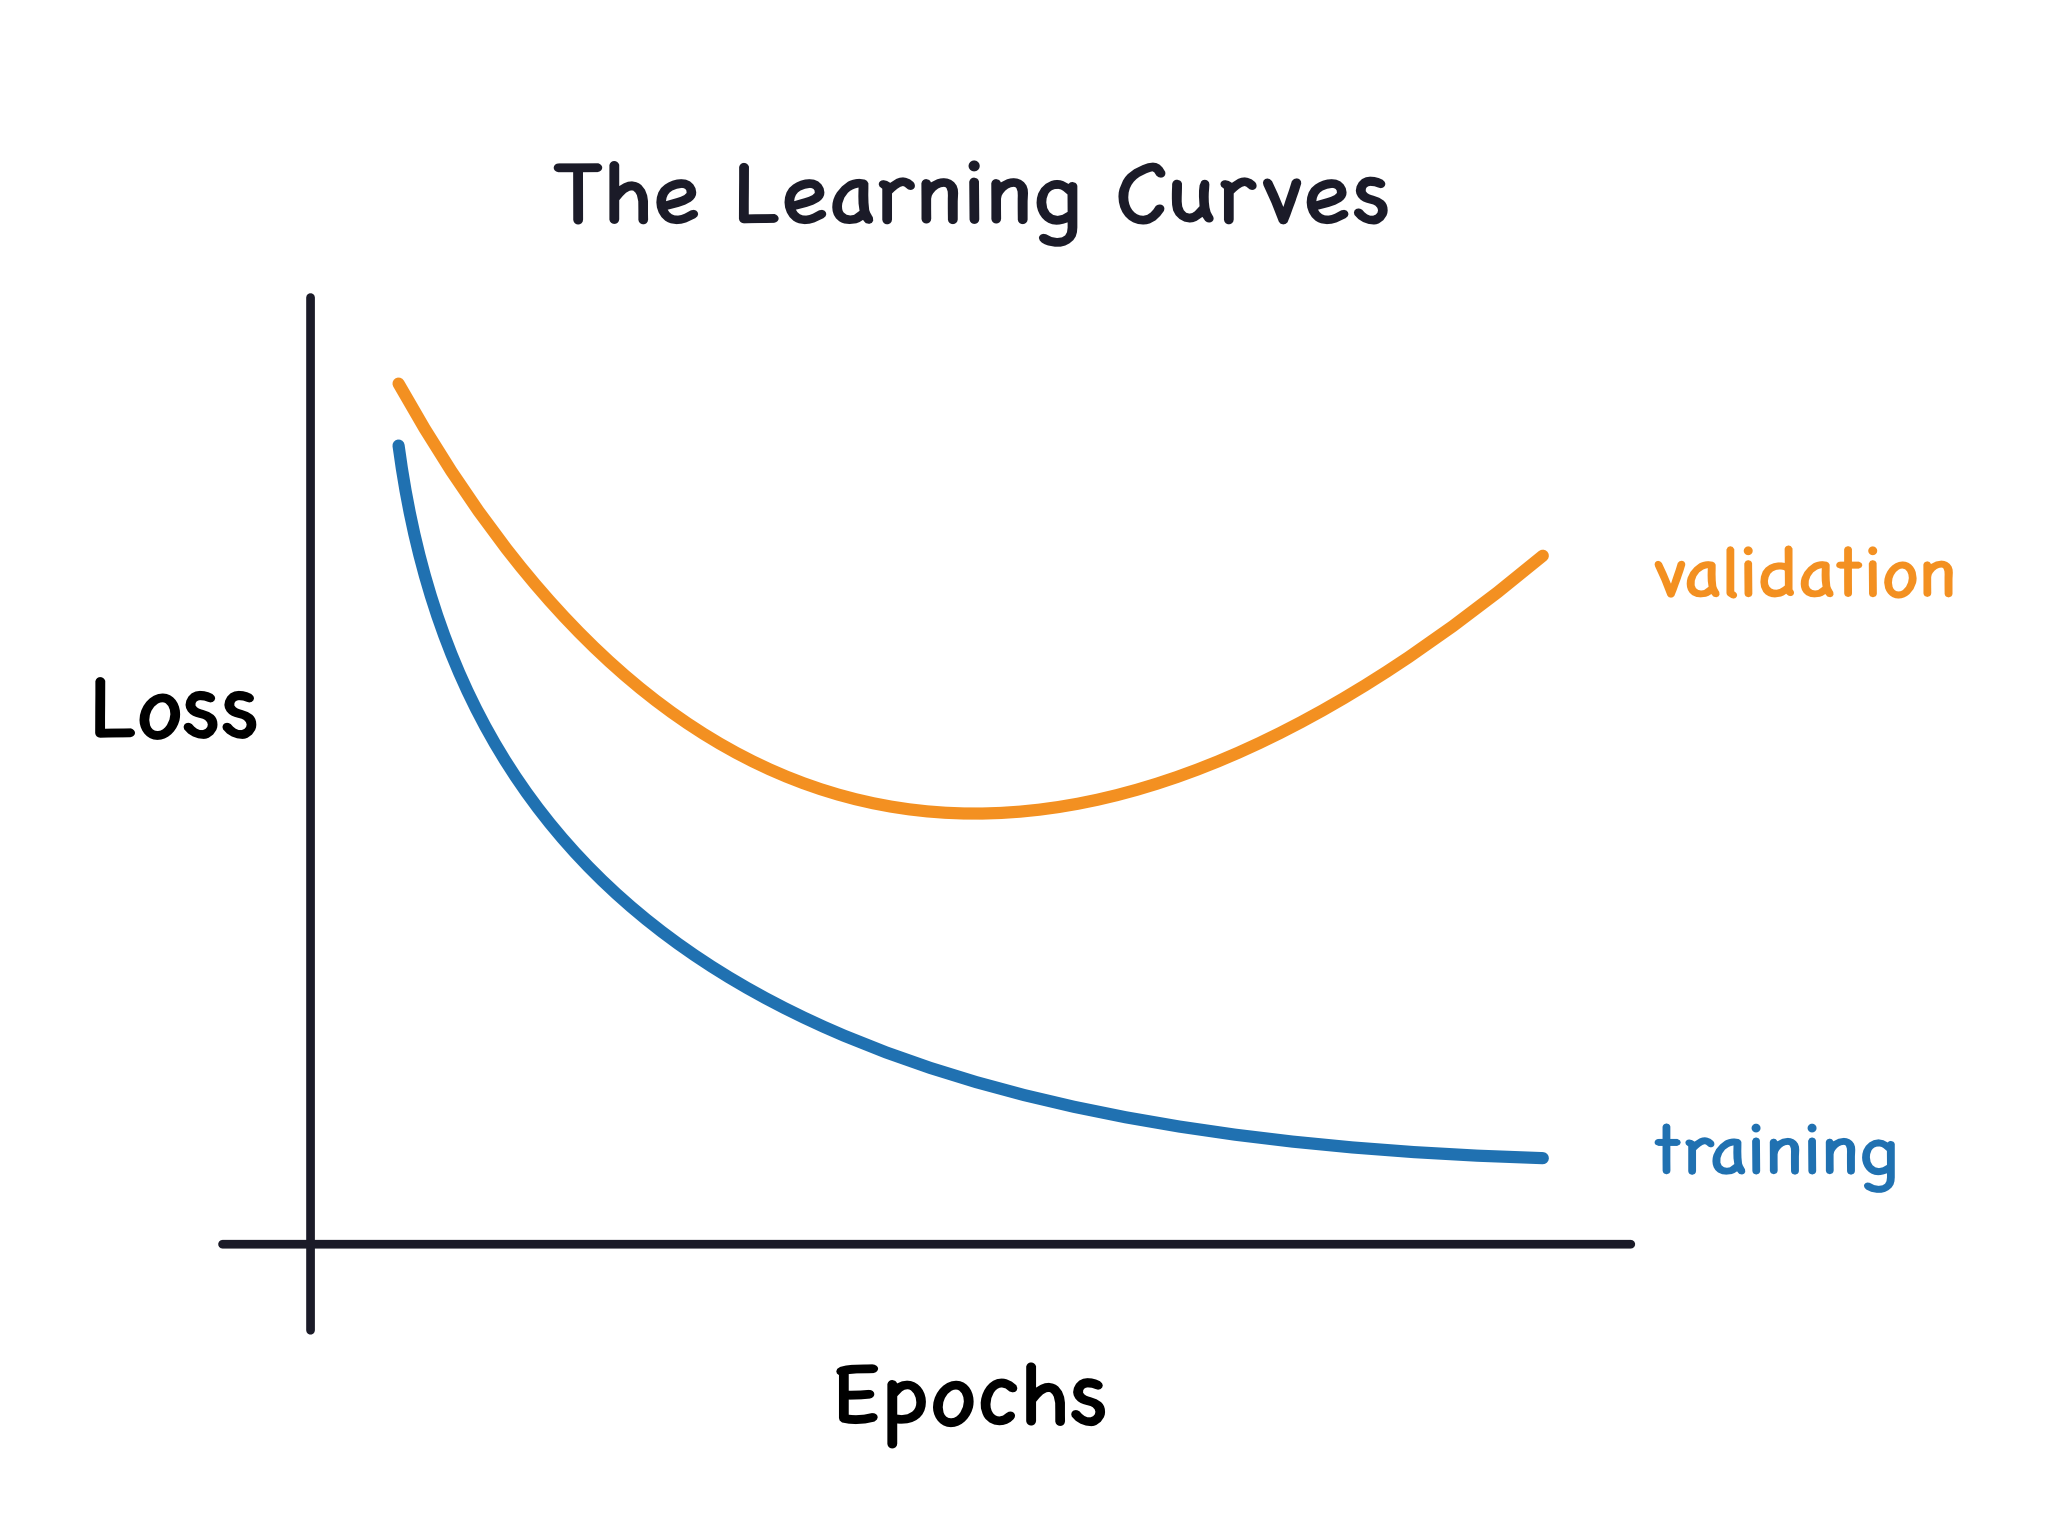The validation loss gives an estimate of the expected error on unseen data.